<a href="https://colab.research.google.com/github/DariaAlekseeva/causal_inference_uplimit_course/blob/main/Daria_Causal_Inference_Week_3_Project_Applying_Difference_in_Differences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> 1. DUPLICATE THIS COLAB TO START WORKING ON IT. Using File > Save a copy to drive.
> 2. SET THE "General Access" OF THE COPIED NOTEBOOK TO "Anyone with the link" BY CLICKING ON "Share" TO ENABLE SHARING WITH YOUR PEERS FOR REVIEW.

### This project is from the *Causal Inference for Data Science course on CoRise.* Learn more about the course [here](https://corise.com/course/causal-inference-for-data-science).



---





# Week 3 Project: Applying Difference-in-Differences
***

Welcome to the third project for Causal Inference for Data Science!

This project marks the end of our core curriculum. After this week, we'll take a brief tour of advanced methods by relating them to the ones you've already learned. We'll also work on a final "wrap-up" project that you can add to your data science portfolio.

But we're getting ahead of ourselves: We still need to complete Week 3 :)


## Scenario

Your previous analyses have gone viral within Tongass. Suddenly, everyone is talking about the "dynamic synergies" between in-store and online sales.

Pretty soon, you get a call from the CEO. "I'm blown away," she says.

"Uh, thanks," you say, trying to keep it cool.

"I'm *so* blown away that I've decided to launch new physical locations in the tri-state area. Customers in New Jersey, New York, and Connecticut will have way more options going forward!"

"Wow!" you reply. "That's amazing."

"Indeed, but I want to make sure we approach this launch thoughtfully before we expand to other geos. Could you analyze the impact of opening new stores in these states?"

"Of course!" you say. "I'll make sure we have a solid causal inference plan and get a rigorous read on how these openings affect Tongass's business."

"Causal inference what now?"

"Sorry," you reply. "The point is: We're going to show Amazon who's boss."

"Excellent!" she says.


## Project notes

As always, we start with the same notes:

### Data

We will work with a consistent data set througout this course (we introduce the data set more fully below). Not all parts of the data set will be applicable in any given week. The goal is demonstrating how a single set of granular data can be transformed to apply different causal inference techniques. We also hope to convey that manipulating data is in many ways the most important aspect of statistical modeling.

### Structure

We attempt to strike a balance between providing concrete steps to follow and making room for exploration. That said, we encourage you to explore: The best way to become a causal inference expert is to attack a single problem from multiple angles to see how different modeling choices affect an analysis. If this freedom is overwhelming, **don't panic**! You can simply fill out the code blocks marked "TODO" and ignore the optional ones. When we ask you to build models, we will provide the treatment effect you should expect so you can check your work.

In [1]:
# loading necessary packages
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

import statsmodels.formula.api as smf

## I. Load the data
***

We will work with a consistent data set throughout this course. The data set is in the file called `tongass_transactions.csv`.

Note: The data set is at the **transaction level**, not the customer level. Any given customer can (and likely does) have multiple transactions. Some measures and fields are at the customer level, while others are at the transaction level. It will be up to you to manipulate this data set so that it can be used for analysis. As we'll discuss, this week's problem can be tackled at different levels of aggregation (e.g., individuals, states, treatment v. control groups). We'll need to be thoughtful about how to aggregate our data.

Below, we define the fields that are relevant for this week:
- `customer_id`: the unique identifier for a given customer
- `age`: the age of the customer
- `income`: the income of the customer
- `state`: the customer's state of residence
- `distance`: the distance (in miles) from a customer's home to the nearest Tongass store
- `tx_order`: whether the transaction is the customer's first, second, third... etc.
- `amount`: the dollar value of the transaction
- `tx_date`: the date of the transaction
- `is_credit`: whether the transaction involved a credit card or a different payment method (1 if credit card, 0 if other)
- `in_store`: whether the transaction happened in a physical store (1 if yes, 0 if no and happened on tongass.com)

**NOTE**: If we don't mention a field above, then it won't be relevant for this week :)

In [2]:
# TODO: read in data (already filled out for you :)
url = 'https://raw.githubusercontent.com/dsaber/co-rise-causal-inference/main/tongass_transactions.csv'
df = pd.read_csv(url)
df.head()

,customer_id,age,income,state,received_re,received_in_store_re,distance,index,tx_order,amount,in_store,tx_date,is_credit,is_bonus
0,0,65,122753,ND,0,0,6.765402,0,0.0,61.964375,0.0,2020-12-31,0.0,0.0
1,0,65,122753,ND,0,0,6.765402,1,1.0,41.057234,0.0,2021-03-31,0.0,0.0
2,0,65,122753,ND,0,0,6.765402,2,2.0,71.752128,1.0,2021-06-30,1.0,0.0
3,0,65,122753,ND,0,0,6.765402,3,3.0,93.129942,1.0,2022-10-31,1.0,0.0
4,1,79,32977,DC,0,0,3.146723,0,0.0,61.334116,0.0,2020-01-31,0.0,0.0


## II. Modify the data set to prepare it for difference-in-differences analysis
***

In previous weeks, we got familiar with the data set. (If we hadn't, we would recommend repeating that step from Week 1!)

Now, we want to approach our data through the lens of difference-in-differences specifically.

First, that means adding in "treatment" and "time period" variables. Let's do that below.

In [3]:
treated_states = ['NJ', 'NY', 'CT'] # stores open in these states, so treatment will be if state shows up within these states
store_opening_date = '2021-03-31' # stores open during this month, so treatment period will be any observation at/after this time

In [8]:
# TODO: use the "treated_states" list to create a column for whether
# an observation is in treatment group; use the "store_opening_date" variable
# to create a column for whether an observation happens after treatment begins. keep in mind
# that using 1s and 0s is more convenient than "True"s and "False"s when it comes to
# fitting linear regressions
df['is_treated_state'] = df.state.apply(lambda x: 1 if x in treated_states else 0) # TODO: determine if state is one of three treated by changing True
df['is_post_treatment'] = df.tx_date.apply(lambda x: 1 if x >= store_opening_date else 0) # TODO: determine if tx_date >= store opening by changing True

## III. Aggregate the data set to the appropriate "level" and vet the parallel trends assumption; this also helps us see if our causal question is worth answering (spoiler: it will be)
***

As you know, difference-in-differences analysis hinges on a critical assumption known as "parallel trends" — that is, in the absence of the treatment, the treatment group would have seen the same trends as the control group.

Unfortunately, we can never be 100% confident in parallel trends; however, we can at least gain some comfort with it.

One way is by comparing the treatment and control groups visually to see whether they follow parallel trends prior to treatment. Try this now.

The [seaborn lineplot function](https://seaborn.pydata.org/generated/seaborn.lineplot.html) is particularly helpful here.

**Keep in mind that we could do this analysis at multiple "levels"**: in particular, we could visualize and model the effect of treatment on individual customers, states, or treatment/control groups overall. Similarly, we could aggregate the data to the month level or simply to the "pre/post" level. For this project, we'll aggregate the data to the "state" and "month" level, but there is no right answer here. Indeed, we'd encourage you to experiment with different levels of analysis to see how that changes your modeling process, but we'll leave that to the optional section below ;)

In [9]:
# TODO: aggregate data to state/month level and visualize treatment versus control for parallel trends like we did in lecture/written material
dfg = df.groupby(['state', 'tx_date', 'is_treated_state', 'is_post_treatment']).agg({
    'amount': 'sum' # outcome variable of interest
    # TODO (OPTIONAL): See optional section below — you could include other control variables
    # here that might lead to more precise estimates of the treatment effect, but there
    # are important nuances to keep in mind
}).reset_index()

In [12]:
# TODO: Visually inspect the parallel trends assumption

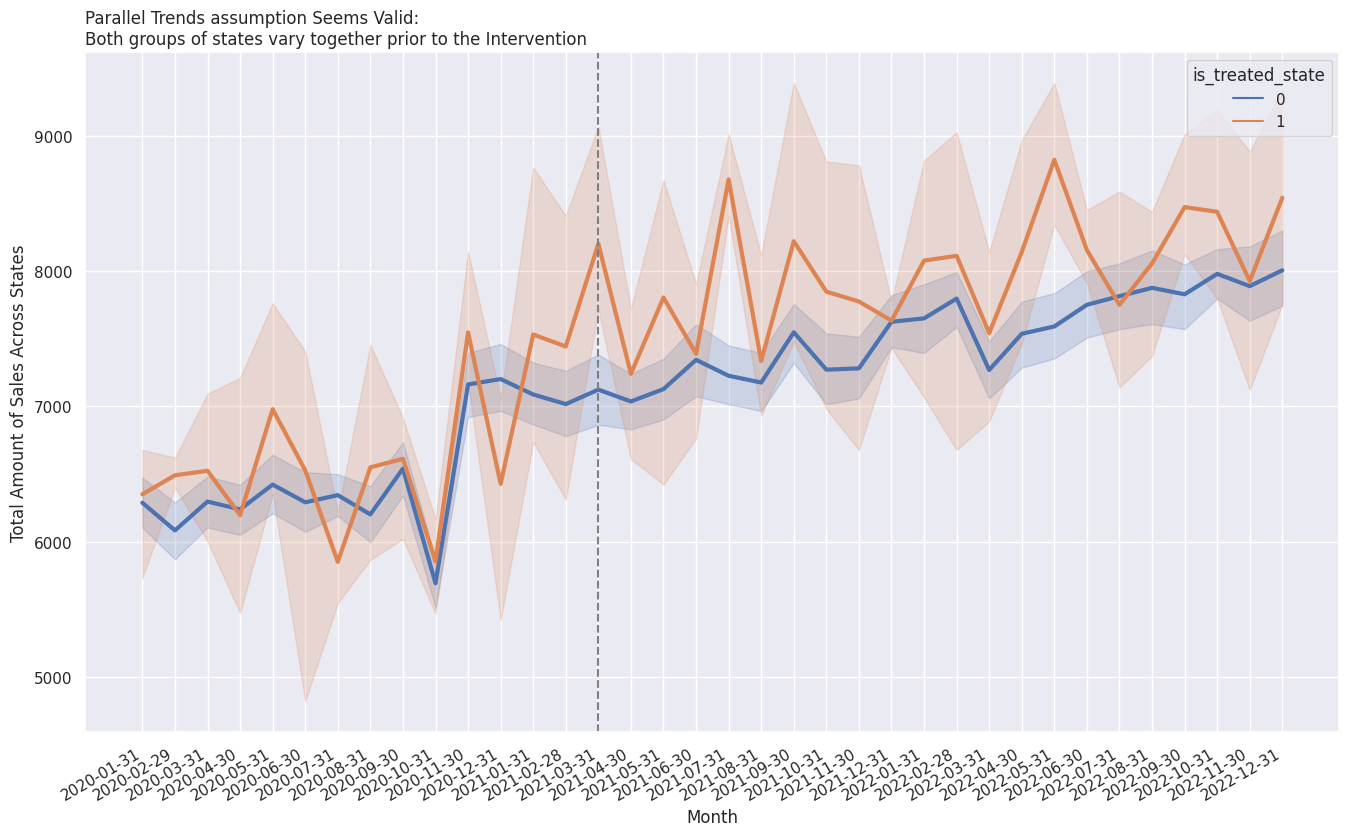

In [16]:
fig, ax = plt.subplots(1,1, figsize=(16.18, 10))

sns.lineplot(
    x='tx_date', y="amount", hue="is_treated_state", data=dfg, ax=ax, lw=3
)

ax.set_title(
  "Parallel Trends assumption Seems Valid:\nBoth groups of states vary together prior to the Intervention",
  loc="left",
)
ax.set_xlabel("Month")
ax.set_ylabel("Total Amount of Sales Across States")

fig.autofmt_xdate()
ax.axvline(store_opening_date, ls="dashed", color="grey")

## IV. Fit difference-in-differences model and interpret the results
***

Woohoo! It's finally time to start modeling. Fit a DD regression using state and month as controls (similar to how we fit a DD regression using farm and month as controls in this week's material).

In [ ]:
# TODO: fit a difference-in-differences model and interpret the results

# CHECK: depending on how you aggregate your data and which additional controls you include, your
# treatment effect should be ~329 (with a 95% CI of 48 to 610)

In [20]:
df_model_1 = smf.ols('amount ~ state + tx_date + is_treated_state:is_post_treatment', data = dfg).fit()
df_model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 amount   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     24.51
Date:                Sat, 13 Jan 2024   Prob (F-statistic):          3.39e-239
Time:                        18:23:25   Log-Likelihood:                -14601.
No. Observations:                1836   AIC:                         2.938e+04
Df Residuals:                    1749   BIC:                         2.986e+04
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                           6184.8589    152.622     40.524      0.000    5885.518    6484.199
state[T.AL]                         -619.4054    166.119     -3.729      0.000    -945.218    -293.592
state[T.AR]                         -327.9062    166.119     -1.974      0.049    -653.719      -2.093
state[T.AZ]                         -643.2972    166.119     -3.873      0.000    -969.110    -317.484
state[T.CA]                          169.7867    166.119      1.022      0.307    -156.026     495.600
state[T.CO]                          422.1350    166.119      2.541      0.011      96.322     747.948
state[T.CT]                          414.0781    187.816      2.205      0.028      45.711     782.445
state[T.DC]                          362.3420    166.119      2.181      0.029      36.529     688.155
state[T.DE]                         -390.6916    166.119     -2.352      0.019    -716.505     -64.879
state[T.FL]                          -12.8595    166.119     -0.077      0.938    -338.672     312.953
state[T.GA]                         1247.4031    166.119      7.509      0.000     921.590    1573.216
state[T.HI]                         1278.1475    166.119      7.694      0.000     952.335    1603.960
state[T.IA]                          781.3229    166.119      4.703      0.000     455.510    1107.136
state[T.ID]                          -79.9592    166.119     -0.481      0.630    -405.772     245.854
state[T.IL]                         -111.1178    166.119     -0.669      0.504    -436.931     214.695
state[T.IN]                         -171.0699    166.119     -1.030      0.303    -496.883     154.743
state[T.KS]                          587.5583    166.119      3.537      0.000     261.745     913.371
state[T.KY]                          105.1522    166.119      0.633      0.527    -220.661     430.965
state[T.LA]                         -259.3723    166.119     -1.561      0.119    -585.185      66.441
state[T.MA]                          365.2311    166.119      2.199      0.028      39.418     691.044
state[T.MD]                          162.0700    166.119      0.976      0.329    -163.743     487.883
state[T.ME]                           -0.6582    166.119     -0.004      0.997    -326.471     325.155
state[T.MI]                          261.1741    166.119      1.572      0.116     -64.639     586.987
state[T.MN]                          724.6925    166.119      4.362      0.000     398.880    1050.505
state[T.MO]                          145.5447    166.119      0.876      0.381    -180.268     471.358
state[T.MS]                         -261.2434    166.119     -1.573      0.116    -587.056      64.570
state[T.MT]                         -478.4945    166.119     -2.880      0.004    -804.308    -1

In [ ]:
# TODO: convert this to a markdown cell and write a quick explanation of your model's results

In [24]:
%%markdown
By opening new store in each state we see an affect of `329 dollars` in each state that had opened a new shop per month on average.

By opening new store in each state we see an affect of `329 dollars` in each state that had opened a new shop per month on average.


## V. Cluster your standard errors
***

Given how we chose to aggregate our data, we should cluster our standard errors to see if that changes the precision of our estimated treatment effect.

Indeed, regardless of whether we fit our model at the customer- or state-level, it's common to cluster standard errors at the level of treatment (in this case, "state" is the level of treatment). It's also reasonable to try to-way clustering (e.g., at the state- _and_ month-level), although we don't need to worry about that for now.

The key thing to remember about clustering is that it helps us account for subtle correlations between observations. Even if we account for state-level effects by including `state` in our model, our within-state error terms could still be correlated (e.g., if the economy in one or two states randomly booms, it might encourage shoppers in that state to spend more).

Unfortunately, there is no "one-size fits-all" guidance about how to cluster your standard errors. (If you want a ton of detail, [this](https://cameron.econ.ucdavis.edu/research/Cameron_Miller_JHR_2015_February.pdf) is an excellent resource.) We personally like to try different justifiable clustering strategies and pick the most conservative (i.e., least precise), although that is largely a function of us working in data-rich tech industry. If you're dealign with small data sets, you may need to dive deeper here to ensure your inference is valid!

In [ ]:
# TODO: cluster your standard errors at the state-level
# CHECK: Your clustered standard errors should actually be lower than the
# unclustered versions — but remember: that can happen when intra-cluster correlations are negative!
# (In reality... I didn't actually add serial correlation to our data set because generating the synethic data set was already quite complex ;)

In [ ]:
# TODO: pick the version that you feel most confident in (remember: when in doubt, go with conservative option)

In [26]:
dfg["state"] = dfg.state.astype("category")

df_model_1.get_robustcov_results(
    cov_type = "cluster", groups = dfg.state.cat.codes
).summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 86, but rank is 36
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 amount   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     100.0
Date:                Sat, 13 Jan 2024   Prob (F-statistic):           5.28e-36
Time:                        18:40:27   Log-Likelihood:                -14601.
No. Observations:                1836   AIC:                         2.938e+04
Df Residuals:                    1749   BIC:                         2.986e+04
Df Model:                          86                                         
Covariance Type:              cluster                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                           6184.8589     83.739     73.859      0.000    6016.665    6353.053
state[T.AL]                         -619.4054   6.17e-11     -1e+13      0.000    -619.405    -619.405
state[T.AR]                         -327.9062   9.12e-11   -3.6e+12      0.000    -327.906    -327.906
state[T.AZ]                         -643.2972   2.82e-11  -2.28e+13      0.000    -643.297    -643.297
state[T.CA]                          169.7867   1.99e-11   8.54e+12      0.000     169.787     169.787
state[T.CO]                          422.1350   1.26e-11   3.35e+13      0.000     422.135     422.135
state[T.CT]                          414.0781     48.805      8.484      0.000     316.050     512.106
state[T.DC]                          362.3420    3.2e-11   1.13e+13      0.000     362.342     362.342
state[T.DE]                         -390.6916   1.25e-11  -3.12e+13      0.000    -390.692    -390.692
state[T.FL]                          -12.8595   1.25e-11  -1.03e+12      0.000     -12.860     -12.860
state[T.GA]                         1247.4031   4.49e-11   2.78e+13      0.000    1247.403    1247.403
state[T.HI]                         1278.1475   1.32e-11   9.69e+13      0.000    1278.147    1278.147
state[T.IA]                          781.3229   1.24e-11   6.28e+13      0.000     781.323     781.323
state[T.ID]                          -79.9592   5.03e-11  -1.59e+12      0.000     -79.959     -79.959
state[T.IL]                         -111.1178   4.31e-11  -2.58e+12      0.000    -111.118    -111.118
state[T.IN]                         -171.0699   3.86e-11  -4.43e+12      0.000    -171.070    -171.070
state[T.KS]                          587.5583    3.4e-11   1.73e+13      0.000     587.558     587.558
state[T.KY]                          105.1522   1.39e-11   7.55e+12      0.000     105.152     105.152
state[T.LA]                         -259.3723   2.41e-11  -1.07e+13      0.000    -259.372    -259.372
state[T.MA]                          365.2311   1.79e-11   2.04e+13      0.000     365.231     365.231
state[T.MD]                          162.0700   2.51e-11   6.45e+12      0.000     162.070     162.070
state[T.ME]                           -0.6582   1.79e-11  -3.68e+10      0.000      -0.658      -0.658
state[T.MI]                          261.1741   1.57e-11   1.67e+13      0.000     261.174     261.174
state[T.MN]                          724.6925   2.02e-11   3.59e+13      0.000     724.693     724.693
state[T.MO]                          145.5447   1.28e-11   1.14e+13      0.000     145.545     145.545
state[T.MS]                         -261.2434   1.84e-11  -1.42e+13      0.000    -261.243    -261.243
state[T.MT]                         -478.4945   1.86e-11  -2.57e+13      0.000    -478.495    -4

## VI. Tease out the causal mechanism by considering different outcome variables
***

In your analysis above, you likely use `amount` as your dependent variable. But there are other possible dependent variables we could consider, e.g., in-store sales or online sales.

Try repeating your model-fitting process with these dependent variables.

These complementary models help us determine whether opening new stores **only** boosts in-store sales, or whether overall sales increase but at the expense of online sales. Although overall sales is probably most important from a business standpoint, it's still important to understand _why_ a treatment works. We don't want people to think there are "dynamic synergies" between online and physical stores when, in reality, physical stores simply encourage customers to ignore the website.

In [ ]:
# TODO: fit a version of your final model with "in-store sales" as your outcome variable (i.e., repeat above
# analysis but filtering to in_store = 1 during data aggregation)

# CHECK: depending on how you aggregate your data and which additional controls you include, your
# treatment effect should be ~1955

In [ ]:
# TODO: fit a version of your final model with "online sales" as your outcome variable (i.e., repeat above
# analysis but filtering to in_store = 0 during data aggregation)

# CHECK: depending on how you aggregate your data and which additional controls you include, your
# treatment effect should be ~1612

In [ ]:
# TODO: convert this cell to a markdown cell and comment on what this means
# for the causal mechanism we're analyzing

In [29]:
df['amount_in_store'] = np.where(
    df['in_store'] == 1, df['amount'], 0
)

df['amount_online'] = np.where(
    df['in_store'] == 0, df['amount'], 0
)

In [30]:
dfg_2 = df.groupby(['state', 'tx_date', 'is_treated_state', 'is_post_treatment']).agg({
    'amount': 'sum', # outcome variable of interest
    'amount_in_store': 'sum',
    'amount_online': 'sum',
}).reset_index()

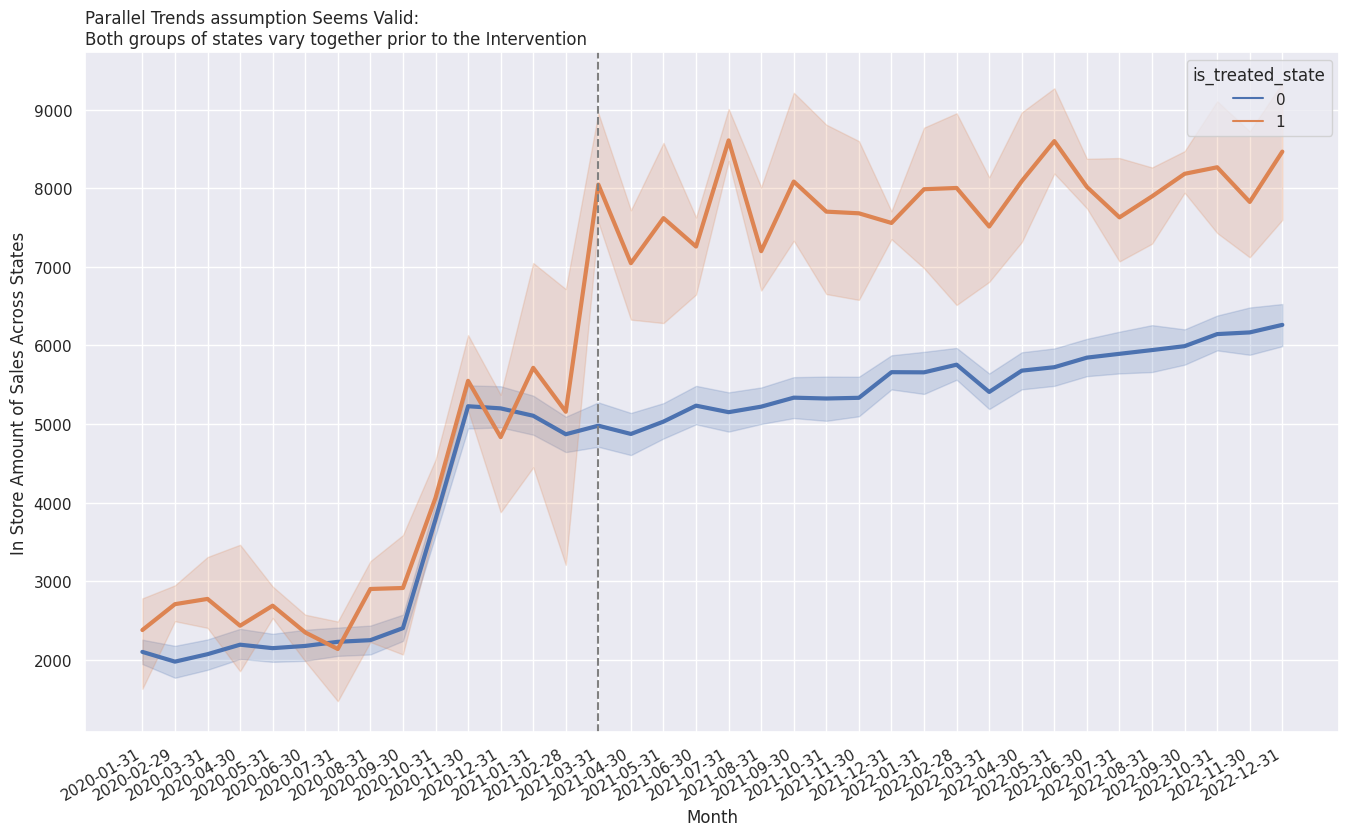

In [32]:
fig, ax = plt.subplots(1,1, figsize=(16.18, 10))

sns.lineplot(
    x='tx_date', y="amount_in_store", hue="is_treated_state", data=dfg_2, ax=ax, lw=3
)

ax.set_title(
  "Parallel Trends assumption Seems Valid:\nBoth groups of states vary together prior to the Intervention",
  loc="left",
)
ax.set_xlabel("Month")
ax.set_ylabel("In Store Amount of Sales Across States")

fig.autofmt_xdate()
ax.axvline(store_opening_date, ls="dashed", color="grey")

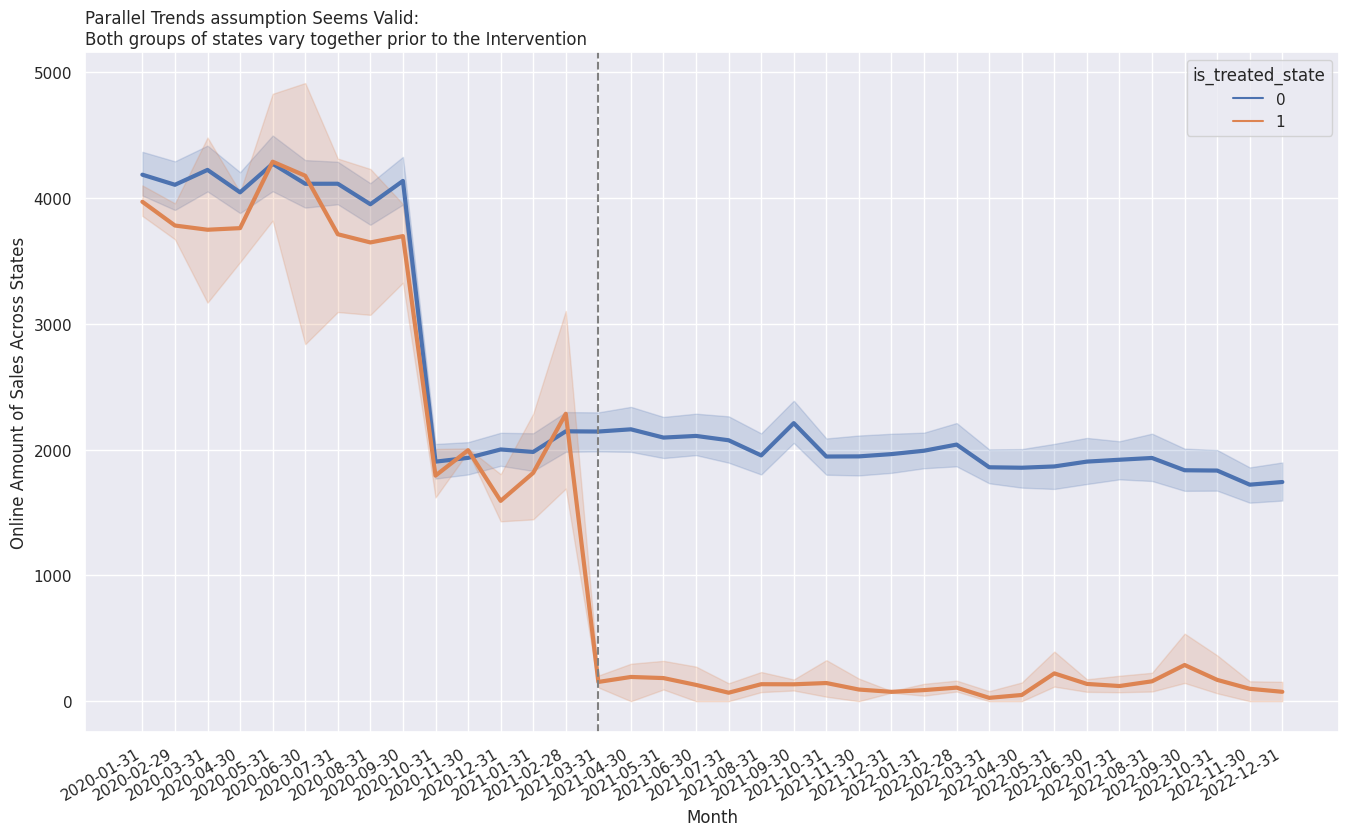

In [33]:
fig, ax = plt.subplots(1,1, figsize=(16.18, 10))

sns.lineplot(
    x='tx_date', y="amount_online", hue="is_treated_state", data=dfg_2, ax=ax, lw=3
)

ax.set_title(
  "Parallel Trends assumption Seems Valid:\nBoth groups of states vary together prior to the Intervention",
  loc="left",
)
ax.set_xlabel("Month")
ax.set_ylabel("Online Amount of Sales Across States")

fig.autofmt_xdate()
ax.axvline(store_opening_date, ls="dashed", color="grey")

In [35]:
df_model_in_store = smf.ols('amount_in_store ~ state + tx_date + is_treated_state:is_post_treatment', data = dfg_2).fit()
df_model_in_store.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        amount_in_store   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     165.2
Date:                Sat, 13 Jan 2024   Prob (F-statistic):               0.00
Time:                        19:07:30   Log-Likelihood:                -14323.
No. Observations:                1836   AIC:                         2.882e+04
Df Residuals:                    1749   BIC:                         2.930e+04
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                           1262.1837    131.198      9.620      0.000    1004.862    1519.505
state[T.AL]                         -228.9498    142.801     -1.603      0.109    -509.028      51.128
state[T.AR]                          175.4763    142.801      1.229      0.219    -104.602     455.554
state[T.AZ]                          202.6329    142.801      1.419      0.156     -77.445     482.711
state[T.CA]                         1293.9542    142.801      9.061      0.000    1013.876    1574.032
state[T.CO]                         1357.0671    142.801      9.503      0.000    1076.989    1637.145
state[T.CT]                         1343.9095    161.452      8.324      0.000    1027.251    1660.568
state[T.DC]                         1493.6096    142.801     10.459      0.000    1213.532    1773.688
state[T.DE]                          616.5549    142.801      4.318      0.000     336.477     896.633
state[T.FL]                          490.2351    142.801      3.433      0.001     210.157     770.313
state[T.GA]                         2411.4563    142.801     16.887      0.000    2131.378    2691.534
state[T.HI]                         1810.6967    142.801     12.680      0.000    1530.619    2090.775
state[T.IA]                         1293.5093    142.801      9.058      0.000    1013.431    1573.587
state[T.ID]                         1154.0329    142.801      8.081      0.000     873.955    1434.111
state[T.IL]                          806.9931    142.801      5.651      0.000     526.915    1087.071
state[T.IN]                          313.3051    142.801      2.194      0.028      33.227     593.383
state[T.KS]                         1491.1668    142.801     10.442      0.000    1211.089    1771.245
state[T.KY]                         1664.7474    142.801     11.658      0.000    1384.669    1944.825
state[T.LA]                           85.0041    142.801      0.595      0.552    -195.074     365.082
state[T.MA]                         1445.8027    142.801     10.125      0.000    1165.725    1725.881
state[T.MD]                          818.2135    142.801      5.730      0.000     538.135    1098.292
state[T.ME]                          545.3582    142.801      3.819      0.000     265.280     825.436
state[T.MI]                         1855.9724    142.801     12.997      0.000    1575.894    2136.050
state[T.MN]                         1288.2870    142.801      9.022      0.000    1008.209    1568.365
state[T.MO]                          747.6294    142.801      5.235      0.000     467.551    1027.707
state[T.MS]                          663.6438    142.801      4.647      0.000     383.566     943.722
state[T.MT]                          211.0882    142.801      1.478      0.140     -68.990     4

In [36]:
df_model_online = smf.ols('amount_online ~ state + tx_date + is_treated_state:is_post_treatment', data = dfg_2).fit()
df_model_online.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          amount_online   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     152.3
Date:                Sat, 13 Jan 2024   Prob (F-statistic):               0.00
Time:                        19:07:57   Log-Likelihood:                -13633.
No. Observations:                1836   AIC:                         2.744e+04
Df Residuals:                    1749   BIC:                         2.792e+04
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                           4922.6752     90.074     54.652      0.000    4746.012    5099.338
state[T.AL]                         -390.4557     98.039     -3.983      0.000    -582.742    -198.169
state[T.AR]                         -503.3825     98.039     -5.134      0.000    -695.669    -311.096
state[T.AZ]                         -845.9300     98.039     -8.628      0.000   -1038.217    -653.643
state[T.CA]                        -1124.1675     98.039    -11.466      0.000   -1316.454    -931.881
state[T.CO]                         -934.9321     98.039     -9.536      0.000   -1127.219    -742.646
state[T.CT]                         -929.8314    110.844     -8.389      0.000   -1147.232    -712.431
state[T.DC]                        -1131.2676     98.039    -11.539      0.000   -1323.554    -938.981
state[T.DE]                        -1007.2466     98.039    -10.274      0.000   -1199.533    -814.960
state[T.FL]                         -503.0946     98.039     -5.132      0.000    -695.381    -310.808
state[T.GA]                        -1164.0531     98.039    -11.873      0.000   -1356.340    -971.767
state[T.HI]                         -532.5492     98.039     -5.432      0.000    -724.836    -340.263
state[T.IA]                         -512.1865     98.039     -5.224      0.000    -704.473    -319.900
state[T.ID]                        -1233.9920     98.039    -12.587      0.000   -1426.279   -1041.705
state[T.IL]                         -918.1109     98.039     -9.365      0.000   -1110.397    -725.824
state[T.IN]                         -484.3750     98.039     -4.941      0.000    -676.662    -292.088
state[T.KS]                         -903.6085     98.039     -9.217      0.000   -1095.895    -711.322
state[T.KY]                        -1559.5951     98.039    -15.908      0.000   -1751.882   -1367.309
state[T.LA]                         -344.3764     98.039     -3.513      0.000    -536.663    -152.090
state[T.MA]                        -1080.5715     98.039    -11.022      0.000   -1272.858    -888.285
state[T.MD]                         -656.1435     98.039     -6.693      0.000    -848.430    -463.857
state[T.ME]                         -546.0164     98.039     -5.569      0.000    -738.303    -353.730
state[T.MI]                        -1594.7983     98.039    -16.267      0.000   -1787.085   -1402.512
state[T.MN]                         -563.5945     98.039     -5.749      0.000    -755.881    -371.308
state[T.MO]                         -602.0846     98.039     -6.141      0.000    -794.371    -409.798
state[T.MS]                         -924.8872     98.039     -9.434      0.000   -1117.174    -732.601
state[T.MT]                         -689.5827     98.039     -7.034      0.000    -881.869    -4

## VII. Consolidate the analysis you performed above so it's useful for a stakeholder
***

### Congratulations!

You've done a ton of incredible work. Now, it's time to package it all together so the Tongas CEO can follow along.

We will annoyingly repeat the same advice from previous weeks:

This step often feels like doing an analysis "in reverse." We don't want to step someone through all the logic we just went through to arrive at our answer (as tempting as that might be). We want to share our answer **first,** then help our stakeholders understand it intuitively by sharing visuals and explaining how confident we can be.

Here is a set of suggested steps, but feel free to tweak as you see fit:
- Share the results from your final model, making sure to put the results in **business terms** (e.g., "opening stores in the tri-state area increased online sales by X and total sales by Y. Assuming stores cost less than Z to operate, or we can continue to increase revenues, we should do this in more states")
- Show key visuals to help someone grok the relationship intuitively
- Comment on our degree of confidence of results, both in quantitative terms (e.g., confidence interval) and qualitative terms (e.g., "model seems robust/sensitive to controls, which means we can be confident/should consider this a preliminary hypothesis warranting deeper experimentation")

In [ ]:
# TODO: change this cell to a markdown cell and write an "executive summary" that
# explains your results

In [ ]:
# TODO: output a key visual (either from above or a new one) that you think communicates
# your results in a statistically responsible way (tip: the same visual you used for parallel
# trends might be helpful here)

In [ ]:
# TODO: change this cell to a markdown cell and write a blurb on how confident you
# are in your results and why

In [42]:
%%markdown
# Executive Summary

Opening stores in the tri-state area decreased online sales by `-1626  dollars` per state per month while increased in store sales by `1955 dollars`.This led to an overall increase in sales by `329 dollars`.
Assuming minimal extra revenue that we want to get is 100 (anything less is meaningless) and if stores cost less than 229 to operate (just to break even), we should do this in more states.
If we can continue to increase revenue from instore sales, it will be more financially viable to open stores in more states.
Model seems robust and, with 95% confidence, we can state that increase in sales is in the range between `168 and	489 dollars` per state per months in state where stores were opened.


# Executive Summary

Opening stores in the tri-state area decreased online sales by `-1626  dollars` per state per month while increased in store sales by `1955 dollars`.This led to an overall increase in sales by `329 dollars`.   
Assuming minimal extra revenue that we want to get is 100 (anything less is meaningless) and if stores cost less than 229 to operate (just to break even), we should do this in more states.
If we can continue to increase revenue from instore sales, it will be more financially viable to open stores in more states.
Model seems robust and, with 95% confidence, we can state that increase in sales is in the range between `168 and	489 dollars` per state per months in state where stores were opened.  


## VIII. OPTIONAL: Consider additional analysis steps
***
1. We didn't ask for this explicitly, but it's possible to include additional controls in our difference-in-difference models to improve the precision of our estimates. For example, we might want to include additional "state-level" variables (e.g., average age of state, average distance of customers in state, etc.) to ensure we account for such differences between states. Consider fitting additional models with these kinds of controls. A few notes about this:
  - Since we already include state-level controls, we should only include additional controls if they _vary_ over time. (If they were stable over time, or "time-invariant," then they would be perfectly correlated with the state controls and cause a perfect multicollinearity problem.)
  - In our case, the controls we could include (e.g., average income by state) _do_ vary over time since the characteristics of our customer-base changes.
  - However, it's important to note that the treatment of opening new stores could *causally affect* the kinds of customers who shop at Tongass. If so, relying on these controls could constitute a **bad controm problem.**
  - The "best" way of accomplishing the spirit of this optional task is by including state-level confounders that we know are far removed for our treatment, e.g., we could include a state's unemployment rate over time, or something more Tongass-specific like our marketing department's spend in each state over time. This is almost certainly overkill for an analysis like ours, but would better capture the goal of including such information in our model. For now, you can practice with these potentially tainted controls to see what happens to our model.
2. We would highly recommend tackling this problem in multiple ways to see how it changes your analysis. For example, you could try aggregating to an even higher level (just treatment v. control groups, just pre v. post time periods) to see and whether that changes your estimated treatment effect. Conversely, it's possible to go the other way and repeat this analysis at the individual _customer_ level. How would that analysis look? What causal question would that analysis be answering? (Note: This gets complicated, and we didn't want to get into all the nuances of panel data methods — that's a broader set of problems than difference-in-differences! That said, if you're interested, consider doing some reading about modeling individual panel data where observations are clustered into higher-level units (in this case, states) and tackling it again). You have all the foundational tools you need to take this on!
3. The [`linearmodels`](https://bashtage.github.io/linearmodels/index.html) package in Python is made for working with panel data (e.g., it doesn't include every single state and month in your regression summary ;). Consider fitting models in this package so you have another tool in your DS arsenal.
4. An important robustness check in some DD models is allowing variable time trends. As mentioned in the written material for this week, differential time trends allow for the possibility that treatment and control groups were following different (non-parallel ;) trends prior to treatment. Consider fitting another model with variable time trends as a robustness check. (TBH, this is mostly so you have practice — we can see from the parallel trends visualization that we don't need to worry about differential time trends.)

## IX. EXTREMELY OPTIONAL: Tackle another problem
***

When it comes to learning causal inference, there is no substitute for practice. We would strongly support finding data sets in the wild (e.g. [here](https://docs.google.com/spreadsheets/d/1wZhPLMCHKJvwOkP4juclhjFgqIY8fQFMemwKL2c64vk/edit#gid=0), [here](https://ourworldindata.org/), or [here](https://github.com/awesomedata/awesome-public-datasets) and using the same general framework we leveraged here toward a causal question you're interested in.